# __Feature engineering__

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.simplefilter('ignore')

## __Encoding time__

As we are dealing with time series, encoding features that are explicit functions of time is very common.

Let's make a dummy dataset to demonstrate ways to encode time.

In [3]:
ds = pd.DataFrame(index=pd.date_range(start=dt.datetime(2018,6,1,1,0,0), end=dt.datetime(2019,6,8,0,0,0), freq='H'))
ds.loc[:, 'y'] = np.random.normal(size=ds.shape[0])

ds.head()

,y
2018-06-01 01:00:00,-0.217618
2018-06-01 02:00:00,-0.244535
2018-06-01 03:00:00,0.889929
2018-06-01 04:00:00,2.042074
2018-06-01 05:00:00,0.687853


If we identified that hour is a useful feature, we could encode it using one hot encoding.  This has the advantage of being simple, at the cost of dimensoinality

In [4]:
pd.set_option('display.max_columns', None)
pd.get_dummies(ds.index.hour).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Another example is to use label encoding (essentially using the column unchanged).  This has an advantage of dimensionality, but the disadvantage of imposing a linear structure.

The model has no ability to understand that hour 23 is close to hour 1.

In [5]:
ds.index.hour

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', length=8928)

### __Sine / cosine transformation of time features__

#### __Linear time representation__

The linear time representation does not account for the inherent time periodicity.

#### __Periodic time representation__

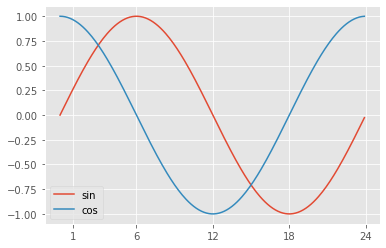

In [6]:
rcParams['figure.figsize'] = 6,4
plt.style.use('ggplot')

X = np.arange(0, 24, 0.1) #note that for a complete period, two overlapping values from within that period have to be included (here: 0 and 24)

y_sin = np.sin(2 * np.pi*X/24)
y_cos = np.cos(2 * np.pi*X/24)

fig = sns.lineplot(X,y_sin,label="sin");
fig = sns.lineplot(X,y_cos,label="cos");

fig.set_xticks([1, 6, 12, 18, 24]);

#file_path = '{}/Desktop/Portfolio_project/presentation/cyclical_time.png'.format(os.environ['HOME'])
#plt.savefig(file_path)

If only a sine OR cosine transformation is done, within one period always two target values would be acribed to the same sine OR cosine value. Hence, always a combined sine / cosine transformation is necessary (see below).

Text(0, 0.5, 'sin(x)')

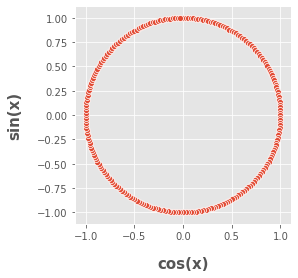

In [7]:
fig = sns.scatterplot(y_sin, y_cos).set_aspect('equal')

plt.xlabel('cos(x)', labelpad=15, fontsize=15, fontweight='bold')
plt.ylabel('sin(x)', labelpad=15, fontsize=15, fontweight='bold')

The sine / cosine transformation does not only consier for the periodicity of time (i.e. hour 23 and hour 2 are in fact in close proximity) but it also reduced the dimensionality from 24 hours to one single sine value and one single cosine value.

### __Let's apply this very transormation to our dataframe__

In [18]:
def time_columns(df):
    
    df = df.copy()
    
    df.loc[:,'minute'] = df.index.minute
    df['hour'] = df.index.hour
    df['weekday'] = np.where(df.index.weekday < 5, 0, 1)
    df['month'] = df.index.month
    df['year'] = df.index.year

    df['minute_sin'] = np.sin(2 * np.pi * df.loc[:,'minute']/60)
    df['minute_cos'] = np.cos(2 * np.pi * df.loc[:,'minute']/60)

    df['hour_sin'] = np.sin(2 * np.pi * df.loc[:,'hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df.loc[:,'hour']/24)
    
    df['month_sin'] = np.sin(2 * np.pi * df.loc[:,'month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df.loc[:,'month']/12)
    
    df.drop(columns=['minute', 'hour', 'month'], inplace=True)
    
    return df

In [9]:
df = pd.read_pickle('../../data/train.pkl')
df.drop(columns=['Price'], inplace=True)
df.head()

,CO2E_EMISSIONS_FACTOR
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


In [10]:
df = time_columns(df)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 937968 entries, 2009-07-01 04:00:00 to 2018-05-31 23:55:00
Freq: 5T
Data columns (total 9 columns):
CO2E_EMISSIONS_FACTOR    937968 non-null float64
weekday                  937968 non-null int64
year                     937968 non-null int64
minute_sin               937968 non-null float64
minute_cos               937968 non-null float64
hour_sin                 937968 non-null float64
hour_cos                 937968 non-null float64
month_sin                937968 non-null float64
month_cos                937968 non-null float64
dtypes: float64(7), int64(2)
memory usage: 71.6 MB


In [12]:
df.head()

,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos
2009-07-01 04:00:00,0.991217,0,2009,0.000000,1.000000e+00,0.866025,0.5,-0.5,-0.866025
2009-07-01 04:05:00,0.000000,0,2009,0.500000,8.660254e-01,0.866025,0.5,-0.5,-0.866025
2009-07-01 04:10:00,0.000000,0,2009,0.866025,5.000000e-01,0.866025,0.5,-0.5,-0.866025
2009-07-01 04:15:00,0.991217,0,2009,1.000000,2.832769e-16,0.866025,0.5,-0.5,-0.866025
2009-07-01 04:20:00,1.025701,0,2009,0.866025,-5.000000e-01,0.866025,0.5,-0.5,-0.866025


### __Using lagging for target prediction__

### __Lagging__
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> as we'll see in upcoming sections.

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>

### __Lagging example__

Below you see an example of lagging. Here, lag1 to lag12 represent $y_{t-1}$ to $y_{t-12}$. The horizon0 values column represents the target values. Can you find the first value of horizon0 anywhere else in the dataframe?
<br/>
<br/>
<img src="../images/lag_examples.jpg"> <br/>

<img src="../images/lag_examples1.jpg"> <br/>

### __Lagging application to our dataset__

But why even use it? In the previous notebook #7 we found a set of time features which appeared to correlate with our target of marginal CO2 emissions. However, these findings were all based on averaged trends over the whole time period of about 9 years (train < whole dataset). From the visualisation of an exemplarly 48h period of the dataset, the occurrence of our marginal CO2 emissions seems alomst erratic and it is likely that the CO2 emissions at a given time point depend on the previous precedent emissions values right before that.

In the above illustration you can see how lagging can do that for us.

#### __How to decide on a number of lags?__

In order to decide on  a number of lags which impact our target value, we take recourse to partial autocorrelation functions (pacf) analogous to autocorrelation functions (acf) we saw in the previous notebook 'data_visualisation'.

The main difference between acf and pacf is that pacf reflect the __specific__ correlation between any considered lag (lag n) and the current value (lag 0) while acf shows the correlation of that superimposed with the correlations of the lags (lag n-1, lag n-2 etc.) before that lag of interest (lag n).

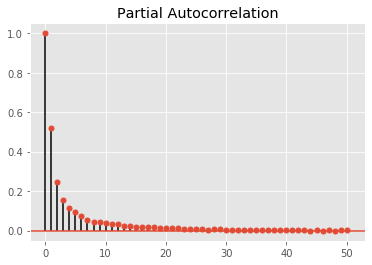

In [17]:
plot_pacf(df.CO2E_EMISSIONS_FACTOR, lags=50);

__It is hardly noticable but the plot show an area of a 95% confidence interval. Each lag n which lies outside it can be considered to significantly correlate to the indicated degree on the y axis with the present time point (lag 0). For us, we can clearly say that at all lags up tp lag 12 appear to significantly correlate with lag 0. Hence, we will use lags 1-12 as features for our forecasts.__

Besides the dataframe, the following function takes the desired number of lags as well as the horizon as an input. The horizon describes how far into the future we would like to forecast a value of marginal CO2 emissions. For instance, a horizon0 describes to predict a value of marginal CO2 right after a sequence of lags, hence forecast 5 min into the future, which is excactly what is illustrated above. A horizon of 1 would skip one value after the sequence and try to predict the marginal CO2 emissions after that, i.e. try to predict 10 min into the future.

__What we apply to our dataset in the following is exactly what is illustrated above. Of course, we won't include a lag0 feature, as that represents the target we wish to predict. Above its sole purpose is for illustration.__

In [19]:
def lag_horizon(df, lag, horizon):
    '''
    Returns dataset with additional features defined by lag and modified target defined by horizon
    lag=integer of how far back time series should look
    horizon=integer of how far into the future the model shall predict; horizon=0 means prediciton 1 step into future
    '''
    df = df.copy()
    
    for i in range(1,lag+1):
        df[f'lag{i}'] = df['CO2E_EMISSIONS_FACTOR'].shift(i)
    
    for i in range(1,horizon+2):
        df[f'horizon{i-1}'] = df['CO2E_EMISSIONS_FACTOR'][lag:]
        
    return df

In [25]:
df = lag_horizon(df, 12, 0)

In [27]:
df.iloc[:18,9:]

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0
2009-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:05:00,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:10:00,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:15:00,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:20:00,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:25:00,1.025701,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:30:00,0.910143,1.025701,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:35:00,0.910143,0.910143,1.025701,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:40:00,0.910143,0.910143,0.910143,1.025701,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:45:00,0.910143,0.910143,0.910143,0.910143,1.025701,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN


In [29]:
df.head()

,CO2E_EMISSIONS_FACTOR,weekday,year,minute_sin,minute_cos,hour_sin,hour_cos,month_sin,month_cos,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,horizon0
2009-07-01 04:00:00,0.991217,0,2009,0.000000,1.000000e+00,0.866025,0.5,-0.5,-0.866025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:05:00,0.000000,0,2009,0.500000,8.660254e-01,0.866025,0.5,-0.5,-0.866025,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:10:00,0.000000,0,2009,0.866025,5.000000e-01,0.866025,0.5,-0.5,-0.866025,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:15:00,0.991217,0,2009,1.000000,2.832769e-16,0.866025,0.5,-0.5,-0.866025,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01 04:20:00,1.025701,0,2009,0.866025,-5.000000e-01,0.866025,0.5,-0.5,-0.866025,0.991217,0.000000,0.000000,0.991217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
file_path = '../../big_data/train_time_features.pkl'
df.to_pickle(file_path)